# 05 — Final Outputs, Summaries, and District-Level Analysis

This notebook consolidates the results from the previous stages of the project.
The goal is to translate the analytical work (impervious mapping, feature engineering,
suitability scoring, and ML validation) into clear and interpretable outputs that can
be used for reporting, communication, and future development.

More specifically, we will:

1. Aggregate suitability scores and classes across Göteborg’s stadsområden.
2. Summarise the total extent of impervious surfaces by suitability category.
3. Produce final static and interactive maps centred on greening suitability.
4. Export polished tables and datasets for use in the README or external tools.
5. Provide a coherent view of where greening opportunities might exist, given the
   limitations of the historical data and the exploratory nature of the framework.

This notebook does not introduce new analytical methods; instead, it organises, visualises,
and interprets the outputs of Notebooks 01–04.


In [2]:
import pathlib

import pandas as pd
import geopandas as gpd
import numpy as np
import matplotlib.pyplot as plt

import folium
from IPython.display import IFrame

# Base project directories
PROJECT_DIR = pathlib.Path("..").resolve()

DATA_RAW = PROJECT_DIR / "data" / "raw"
DATA_PROCESSED = PROJECT_DIR / "data" / "processed"
OUTPUTS = PROJECT_DIR / "outputs"
MAPS_DIR = OUTPUTS / "maps"
FIGURES_DIR = OUTPUTS / "figures"

DATA_PROCESSED, MAPS_DIR, FIGURES_DIR


(WindowsPath('D:/Programming/geo-projects/impervious-to-green-gbg/data/processed'),
 WindowsPath('D:/Programming/geo-projects/impervious-to-green-gbg/outputs/maps'),
 WindowsPath('D:/Programming/geo-projects/impervious-to-green-gbg/outputs/figures'))

In [3]:
# Full data with suitability index and classes
scores_path = DATA_PROCESSED / "impervious_with_scores.gpkg"
impervious = gpd.read_file(scores_path)

# UA-only subset (useful for mapping)
ua_path = DATA_PROCESSED / "ua2018_impervious_with_scores.gpkg"
ua_suit = gpd.read_file(ua_path)

# Boundary 
boundary_path = DATA_PROCESSED / "gothenburg_boundary.gpkg"
gothenburg_boundary = gpd.read_file(boundary_path)

impervious.shape, ua_suit.shape, gothenburg_boundary.shape


((113232, 25), (6151, 25), (1, 8))

## 1. Summaries

In [4]:
# Count polygons per class
class_counts = impervious["suitability_class"].value_counts()
class_percent = impervious["suitability_class"].value_counts(normalize=True) * 100

# Total impervious area per class
area_by_class = impervious.groupby("suitability_class")["area_ha"].sum()

class_counts, class_percent, area_by_class


(suitability_class
 high      37744
 medium    37744
 low       37744
 Name: count, dtype: int64,
 suitability_class
 high      33.333333
 medium    33.333333
 low       33.333333
 Name: proportion, dtype: float64,
 suitability_class
 high      20527.123824
 low        6437.785330
 medium     3111.677116
 Name: area_ha, dtype: float64)

In [5]:
# Group by stadsområde
district_summary = impervious.groupby(["STADSOMRAD", "NAMN", "suitability_class"]).agg({
    "area_ha": "sum",
    "geometry": "count"  # proxy for polygon count
}).reset_index()

district_summary.head()


,STADSOMRAD,NAMN,suitability_class,area_ha,geometry
0,1.0,Nordost,high,4055.428742,4716
1,1.0,Nordost,low,1162.899005,4715
2,1.0,Nordost,medium,547.909190,5812
3,2.0,Centrum,high,3501.092110,6028
4,2.0,Centrum,low,1507.452088,10169


In [6]:
district_pivot = district_summary.pivot_table(
    index=["STADSOMRAD", "NAMN"],
    columns="suitability_class",
    values="area_ha",
    fill_value=0
).reset_index()

district_pivot


suitability_class,STADSOMRAD,NAMN,high,low,medium
0,1.0,Nordost,4055.428742,1162.899005,547.909190
1,2.0,Centrum,3501.092110,1507.452088,712.691462
2,3.0,Sydväst,6039.641145,532.247887,287.513101
3,4.0,Hisingen,6930.961827,3235.186350,1563.563364


In [8]:
# Calculate row-wise total impervious area
district_pivot["total_ha"] = (
    district_pivot["high"] 
    + district_pivot["medium"] 
    + district_pivot["low"]
)

# Percentage contributions
district_pivot["pct_high"] = district_pivot["high"] / district_pivot["total_ha"]
district_pivot["pct_medium"] = district_pivot["medium"] / district_pivot["total_ha"]
district_pivot["pct_low"] = district_pivot["low"] / district_pivot["total_ha"]

district_pivot[[
    "STADSOMRAD", "NAMN", 
    "high", "medium", "low",
    "pct_high", "pct_medium", "pct_low"
]]


suitability_class,STADSOMRAD,NAMN,high,medium,low,pct_high,pct_medium,pct_low
0,1.0,Nordost,3898.395387,246.422372,106.954715,0.916887,0.057958,0.025155
1,2.0,Centrum,3356.910354,202.696094,138.471917,0.907745,0.054811,0.037444
2,3.0,Sydväst,4898.418363,9.319227,4.132121,0.997261,0.001897,0.000841
3,4.0,Hisingen,6748.115112,1040.728963,313.351016,0.832875,0.128450,0.038675


In [6]:
district_csv = DATA_PROCESSED / "district_suitability_summary.csv"
district_pivot.to_csv(district_csv, index=False)
district_csv

WindowsPath('D:/Programming/geo-projects/impervious-to-green-gbg/data/processed/district_suitability_summary.csv')

## 2. Maps

Saved static map to: D:\Programming\geo-projects\impervious-to-green-gbg\outputs\figures\ua2018_suitability_static.png


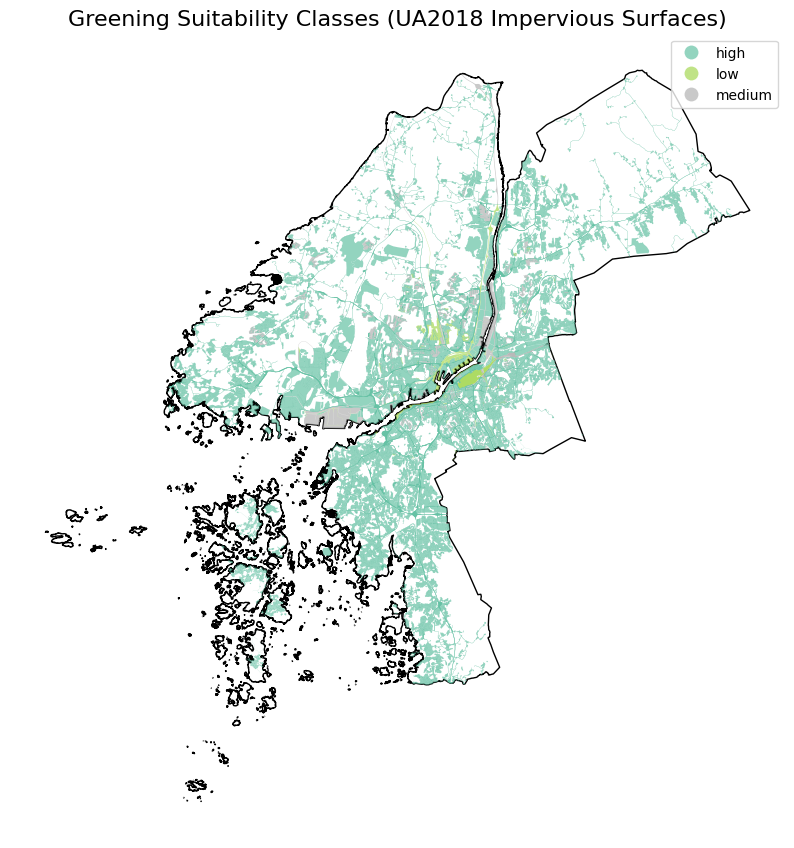

In [7]:
fig, ax = plt.subplots(figsize=(10, 14))

# Plot districts
gothenburg_boundary.boundary.plot(ax=ax, color="black", linewidth=1, zorder=1)

# Plot UA impervious polygons with suitability classes
ua_suit.plot(
    column="suitability_class",
    categorical=True,
    cmap="Set2",
    legend=True,
    ax=ax,
    linewidth=0,
    alpha=0.7,
    zorder=2
)

ax.set_title("Greening Suitability Classes (UA2018 Impervious Surfaces)", fontsize=16)
ax.set_axis_off()

# Save as high-resolution figure
fig_path = FIGURES_DIR / "ua2018_suitability_static.png"
plt.savefig(fig_path, dpi=200, bbox_inches="tight")
print("Saved static map to:", fig_path)

plt.show()


In [9]:
# Convert to WGS84 for Folium
ua_suit_wgs = ua_suit.to_crs(epsg=4326)
boundary_wgs = gothenburg_boundary.to_crs(epsg=4326)

# Colour scheme
suit_colors = {
    "high": "#31a354",   # strong green
    "medium": "#fed976", # warm yellow
    "low": "#de2d26"     # strong red
}

def style_function(feature):
    cls = feature["properties"].get("suitability_class", "medium")
    return {
        "fillColor": suit_colors.get(cls, "#cccccc"),
        "color": None,
        "fillOpacity": 0.6,
        "weight": 0
    }

# Create map
m = folium.Map(
    location=[57.7089, 11.9746],  # Göteborg centre
    zoom_start=11,
    tiles="CartoDB Positron"
)

# Add polygons
folium.GeoJson(
    ua_suit_wgs,
    name="UA2018 suitability",
    style_function=style_function,
    tooltip=folium.GeoJsonTooltip(
        fields=["suitability_class", "suitability_index", "area_ha", "NAMN"],
        aliases=["Suitability", "Index", "Area (ha)", "District"],
        sticky=False
    )
).add_to(m)

# Add boundary overlay
folium.GeoJson(
    boundary_wgs,
    name="Boundary",
    style_function=lambda x: {
        "color": "black",
        "weight": 2,
        "fill": False
    }
).add_to(m)

folium.LayerControl().add_to(m)

# Save
interactive_path = MAPS_DIR / "ua2018_suitability_interactive.html"
m.save(str(interactive_path))
print("Saved interactive map to:", interactive_path)

# Show inline
IFrame(src=str(interactive_path), width=900, height=600)


Saved interactive map to: D:\Programming\geo-projects\impervious-to-green-gbg\outputs\maps\ua2018_suitability_interactive.html


In [9]:
# Exports
# District-level summary
district_export_path = DATA_PROCESSED / "district_suitability_summary.csv"
district_pivot.to_csv(district_export_path, index=False)
print("Saved district summary to:", district_export_path)

# UA2018-only suitability polygons as GeoJSON
ua_suit_geojson_path = OUTPUTS / "ua2018_suitability.geojson"
ua_suit.to_crs(epsg=4326).to_file(ua_suit_geojson_path, driver="GeoJSON")
print("Saved UA2018 suitability GeoJSON to:", ua_suit_geojson_path)

Saved district summary to: D:\Programming\geo-projects\impervious-to-green-gbg\data\processed\district_suitability_summary.csv
Saved UA2018 suitability GeoJSON to: D:\Programming\geo-projects\impervious-to-green-gbg\outputs\ua2018_suitability.geojson


## Interpreting the Suitability Maps and District-Level Patterns

The final suitability maps (both static and interactive) reveal a striking pattern:
large portions of Göteborg’s impervious surfaces appear with **high suitability scores** for greening.
At first glance, this might suggest an implausibly optimistic scenario. However, a closer look
at the data sources, the scoring logic, and the structure of Göteborg’s geography explains
this outcome in a consistent and defensible way.

### 1. Why high-suitability areas dominate the map

The suitability score developed in Notebook 03 highlights **opportunities** for greening, not
**urgency**. It measures where greening would be *physically feasible*, given characteristics such as:

- proximity to existing green or blue structures,
- distance from major roads,
- size of the impervious polygon,
- and morphological compactness.

Many of Göteborg’s impervious polygons, as represented in Urban Atlas 2018, fall into
categories such as low-density urban fabric, industrial yards, or large peripheral lots.
These polygons are often:

- close to green areas,
- far from the dense city centre,
- not adjacent to major roads,
- and large or compact enough to support meaningful green interventions.

In other words, these surfaces **score well because they structurally possess the traits
that the model interprets as favourable for greening**, not because the city is uniformly
suitable for transformation.

It is important to emphasise that this framework does *not* capture socio-spatial priorities,
heat vulnerability, environmental justice, biodiversity deficits, or local constraints.
It offers a first-pass, opportunity-oriented perspective.

### 2. District-level results

Aggregating suitability scores across Göteborg’s four *stadsområden* reveals clear spatial
patterns:

| District | % High | % Medium | % Low |
|----------|--------|----------|--------|
| **Nordost** | 91.7% | 5.8% | 2.5% |
| **Centrum** | 90.8% | 5.5% | 3.7% |
| **Sydväst** | 99.7% | 0.2% | 0.08% |
| **Hisingen** | 83.3% | 12.8% | 3.9% |

These numbers reflect the different morphological and infrastructural characteristics of
each district:

- **Sydväst** is overwhelmingly classified as high suitability because it contains many large,
  peripheral impervious surfaces surrounded by forest and water, with minimal exposure to
  heavy road infrastructure.

- **Nordost** shows a similarly strong pattern, driven by large expanses of low-density and
  semi-rural impervious surfaces.

- **Centrum** also ranks very high in proportion, but the *absolute area* of impervious
  surfaces suitable for greening is much smaller compared to other districts, as the dense
  urban core contains fewer large polygons.

- **Hisingen** presents the most mixed pattern, with 83% high suitability but also the largest
  medium-suitability area, reflecting its combination of industrial surfaces, port areas, and
  more varied geometry.

### 3. Map Results

Given the large proportion of the areas classed as High suitability, we get a predominantly green map. But this visual dominance of high-suitability areas should not be interpreted as suggesting that
most of Göteborg is ready for greening interventions, unfortunately. Instead, it should be read as:

- a reflection of the **Urban Atlas 2018 dataset**, which excludes roads and fine-grained
  pavement infrastructure;
- the result of a **morphological and distance-based model** that rewards physical
  opportunity rather than societal or ecological necessity;
- a demonstration that large peripheral surfaces structurally resemble “greening candidates”
  under this scoring logic.

The framework is thus **exploratory and indicative**, not prescriptive. When combined with
up-to-date datasets, planning constraints, or vulnerability indicators, the same logic could
support more comprehensive decision-making for urban greening.

### 4. Summary

The suitability maps showcase where greening is *physically plausible* according to the
features engineered in earlier notebooks. District-level summaries help contextualise these
results within Göteborg’s varied geography. While the maps show widespread high suitability,
this reflects the structure of the dataset and the nature of the scoring system rather than
an overestimation of greening potential. The results form a solid basis for future work where
additional layers—such as zoning regulations, population exposure, flood risk, or biodiversity
targets—could refine and rebalance the suitability assessment.


## Summary

In this notebook we brought together the full output of the workflow developed in
Notebooks 01–04 and conducted a district-level analysis of greening suitability
across Göteborg’s four *stadsområden*. The purpose of this step was not to
re-examine the suitability scoring or the ML model, but to situate the results
within a meaningful administrative context and generate interpretable,
policy-relevant summaries.

Using the suitability scores generated earlier, we aggregated the total area of
impervious surfaces classified as high, medium or low suitability within each
district. This provides a first approximation of how greening opportunities are
distributed spatially, and allows for comparison across major parts of the city.

The resulting tables, maps and proportions do not prescribe intervention
priorities, but they clarify the structural landscape identified by the model:
large, peripheral impervious surfaces dominate the overall suitability area, and
districts differ substantially in the size and composition of their convertible
surfaces.

This notebook completes the exploratory prototype pipeline:

- Notebook 01 prepared and validated the geospatial datasets.
- Notebook 02 engineered physical, morphological and contextual features.
- Notebook 03 produced a transparent suitability score.
- Notebook 04 demonstrated that these features contain sufficient signal for
  an ML classifier to approximate the scoring logic.
- Notebook 05 summarised results at district level, producing interpretable,
  policy-oriented aggregates.

Together, these steps form a clear, reproducible workflow for analysing
impervious-to-green conversion potential using open geospatial data. The
approach can be expanded with updated land-use datasets, ecological or social
indicators, zoning constraints, or stakeholder-driven prioritisation criteria.
